In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k/Images/3543600125_223747ef4c.jpg
/kaggle/input/flickr8k/Images/2174206711_11cb712a8d.jpg
/kaggle/input/flickr8k/Images/280706862_14c30d734a.jpg
/kaggle/input/flickr8k/Images/2100735137_05c6079537.jpg
/kaggle/input/f

# Importing Libraries

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add


2025-05-05 06:56:27.597106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746428187.797819      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746428187.854257      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Setting up the directory path

In [3]:
Base_dir='/kaggle/input/flickr8k' 
working_dir='/kaggle/working/'


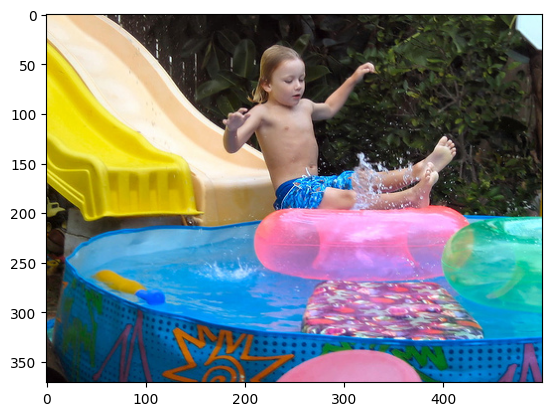

In [4]:
image_name = "1077546505_a4f6c4daa9.jpg"
image_id = image_name.split('.')[0]
img_path = os.path.join(Base_dir, "Images", image_name)
image = Image.open(img_path)
plt.imshow(image)

In [5]:
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


# 2. Image Feature Extraction 

## 2.1 Transfer learning (VGG16)

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Load VGG16 with default settings
model = VGG16()

# Extract features from the second-last layer
moddel = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Print the model summary
print(model.summary())


I0000 00:00:1746428200.401931      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
features = {}
directory = os.path.join(Base_dir , 'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/'+ img_name
    image = load_img(img_path , target_size = (224,224))
    image = img_to_array(image)
    image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    image=preprocess_input(image)
    feature=model.predict(image,verbose=0)
    image_id=img_name.split('.')[0]
    features[image_id]=feature


  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1746428206.395757      93 service.cc:148] XLA service 0x7bef8000ad70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746428206.396358      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746428206.547720      93 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746428208.406642      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


# 3.Text Processing 

## 3.1 open the captions text file

In [8]:
with open(os.path.join(Base_dir,'captions.txt'),'r') as File:
    next(File)
    captions_file = File.read()

## 3.2 Dictionary mapping image IDs to their captions 

In [9]:
mapping = {}
for line in tqdm(captions_file.split('\n')):
    tokens = line.split(',')
    #skips the lines with fewer than 2 characters 
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
def preprocessing(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = caption.replace('[^A-Za-z]','')
            caption = caption.replace('\s+', ' ')
            caption = 'starseq ' + " ".join([word for word in caption .split() if 
                                       len(word) > 1]) + ' endseq '
            captions[i] = caption

preprocessing(mapping)

# 4. Tokenization and splitting

In [11]:
# Used to extract all captions from the mapping dictionary into a single list
all_captions = [caption for key in mapping for caption in mapping[key]]


In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)


# 5. Splitting the data into train and test

In [13]:
image_ids = list(mapping.keys())

train, test = train_test_split(image_ids , test_size = 0.1 ,  random_state = 42)

# 6. Data Generation ( To avoid Memory Issues )

In [35]:
def data_generator(data_keys , mapping , features , tokenizer , max_length , vocab_size , batch_size):
    X1, X2, y = [] , [] ,[] 
    n = 0
    while True:
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(np.reshape(features[key], (-1,)))  # Flattens to 1D
                    X2.append(in_seq)
                    y.append(out_seq)
            n += 1
            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1.clear()  # Clears the content of X1
                X2.clear()  # Clears the content of X2
                y.clear()   # Clears the content of y
                n = 0

    

# 7. Model Architecture

In [36]:
# image feature layers
inputs1=Input(shape=(1000,),name="image")
a=Dropout(0.3)(inputs1)
X=Dense(256,activation='relu')(a)

# sequence feature layers
inputs2=Input(shape=(max_length,),name="text")
c=Embedding(vocab_size,256)(inputs2)
d=Dropout(0.3)(c)
Y=LSTM(256)(d)



decoder1=add([X , Y])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)         │ (None, 35)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image (InputLayer)        │ (None, 1000)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 35, 256)        │      2,172,160 │ text[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 1000)           │              0 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 35, 256)        │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 256)            │        256,256 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 256)            │        525,312 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 256)            │              0 │ dense_6[0][0],         │
│                           │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 256)            │         65,792 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 8485)           │      2,180,645 │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,200,165 (19.84 MB)

 Trainable params: 5,200,165 (19.84 MB)

 Non-trainable params: 0 (0.00 B)

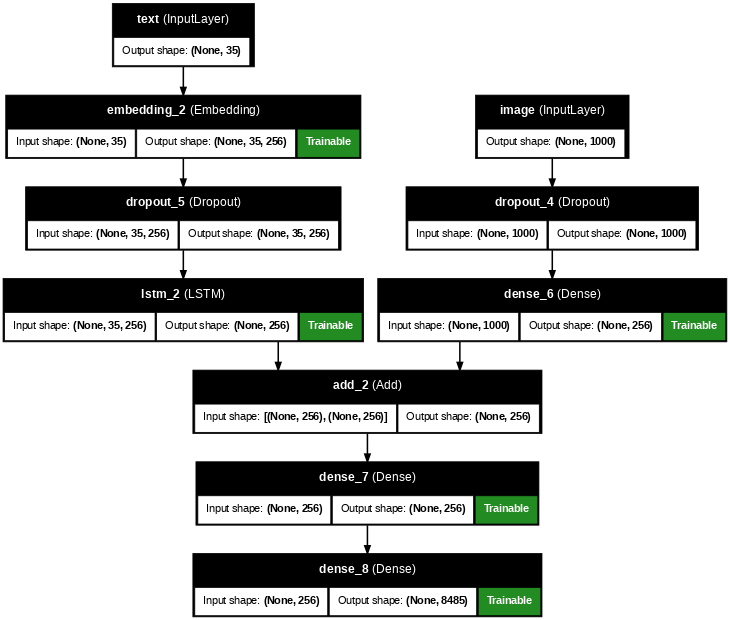

In [37]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    dpi=55,
    show_layer_activations=False,
    show_trainable=True
    
)

# 8. Training the Model

In [39]:
epochs = 12
batch_size = 32
steps=len(train)//batch_size

for i in range(epochs):
    generator = data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
    model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 221ms/step - loss: 6.2380
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 220ms/step - loss: 4.5929
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 220ms/step - loss: 4.1562
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 219ms/step - loss: 3.9253
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 221ms/step - loss: 3.7616
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 218ms/step - loss: 3.6310
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 220ms/step - loss: 3.5165
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 223ms/step - loss: 3.4167
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 220ms/step - loss: 3.3304
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 220ms/step - loss: 3.2553
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 219ms/step - loss: 3.1871
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 219ms/step - loss: 3.1245


# 9. Generate Captions for the Image

In [40]:
def convert_to_word(number, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == number:
            return word
    return None


def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        y_pred = model.predict([image, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = convert_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
      
    return in_text

In [41]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(Base_dir, "Images", image_name)
    image = Image.open(img_path)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print(y_pred)
    plt.imshow(image)

startseq of football players in red and white uniforms are playing soccer endseq


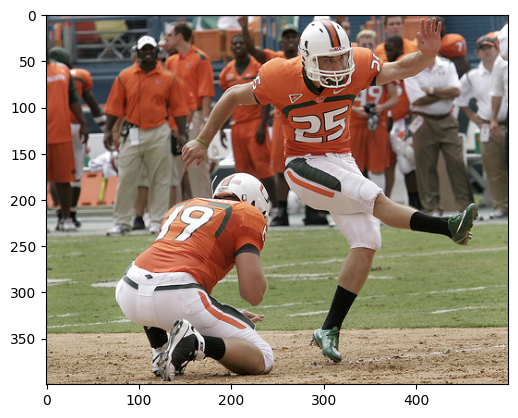

In [45]:
generate_caption("2894217628_f1a4153dca.jpg")

# 10. BLEU Score 

In [46]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = [] , []

for key in tqdm(test):

    captions = mapping[key] 
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

    # calcuate BLEU score
#Unigram
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
#Bigram
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.418954
BLEU-2: 0.212013


# 11. Save the Model

In [47]:
model.save('model.h5')

In [48]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))